In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=7, cores=7,walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=8)
#
client = Client(cluster)

In [3]:
root_dir = '/home1/datawork/zcaspar/mit4320/'
fig_dir = root_dir+ 'Figures_manuscript/'

#Signal
#_ds_hf = xr.open_zarr(root_dir+'ds_hf.zarr')
#ds_total = xr.open_zarr(root_dir+'ds_total.zarr')


#Energy
ds_hf = xr.open_dataset(root_dir+'E_hf.nc')
ds_total = xr.open_dataset(root_dir+'E_total.nc')

#Autocovariance
autocov_hf = xr.open_dataset(root_dir+'hf_autocov_complex.nc').persist()
autocov_total = xr.open_dataset(root_dir+'total_autocov_complex.nc').persist()#[['MS_real_real','MS_real_imag']].persist()

In [4]:
autocov_hf

<xarray.Dataset>
Dimensions:              (T: 4, T_low: 3, bandwidth: 3, draw: 500, rms: 4, signal: 3, lags: 3601)
Coordinates:
  * T                    (T) float64 5.0 10.0 20.0 40.0
  * T_low                (T_low) float64 2.0 20.0 200.0
  * bandwidth            (bandwidth) float64 0.2 0.4 0.6
  * draw                 (draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
    filt                 int64 ...
  * rms                  (rms) float64 0.01 0.1 1.0 2.0
  * signal               (signal) object 'coherent' 'mixed' 'incoherent'
  * lags                 (lags) float64 0.0 0.04167 0.08333 ... 150.0 150.0
Data variables:
    M2_demodulated_real  (bandwidth, signal, rms, T_low, draw, T, lags) float64 ...
    M2_demodulated_imag  (bandwidth, signal, rms, T_low, draw, T, lags) float64 ...

In [23]:
_ = autocov_total.MS_real_real#.compute()

In [24]:
_mean = _.mean('draw').compute()

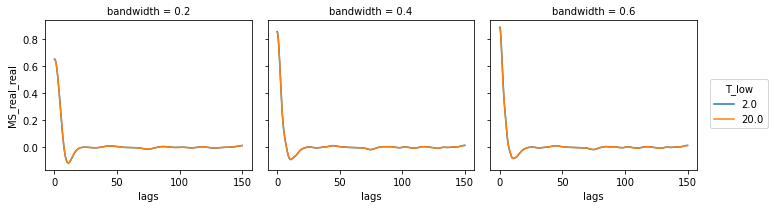

<Figure size 432x288 with 0 Axes>

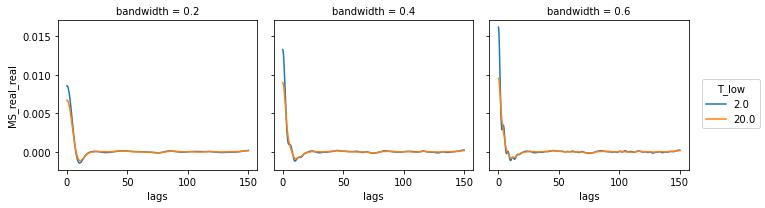

In [25]:
_mean.sel(rms=1,signal='incoherent',T=5).sel(lags=slice(0,150),T_low=[2,20]).plot(col='bandwidth',hue='T_low')
#.sel(T=[5,40])
plt.figure()
_mean.sel(rms=0.01,signal='incoherent',T=5).sel(lags=slice(0,150),T_low=[2,20]).plot(col='bandwidth',hue='T_low')

### Filters + filtered signal

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

In [5]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [6]:
import scipy.signal as signal
dband = [0.1,0.2,0.3] #0.05,
dt = 1/24
Tw = 30
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

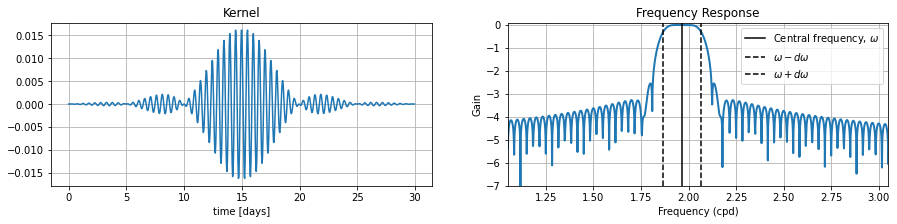

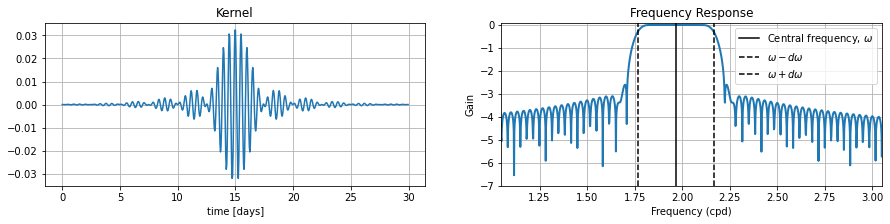

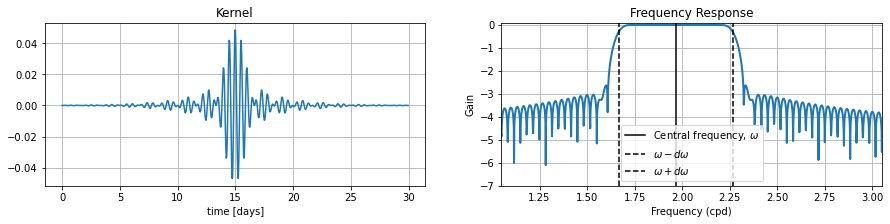

In [6]:
for filt in h.keys():
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    ax = axes[0]
    ax.plot(np.arange(0,Tw,dt),h[filt])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')

    ax = axes[1]
    ax.plot(w[filt], np.log10(abs(h_hat[filt])), linewidth=2)
    ax.axvline(omega, color='k',label=r'Central frequency, $\omega$')
    ax.axvline(omega-float(filt),linestyle='--', color='k',label=r'$\omega-d\omega$')
    ax.axvline(omega+float(filt),linestyle='--', color='k',label=r'$\omega+d\omega$')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(1.05, 3.05)
    ax.grid(True)
    ax.legend()
    fig.savefig(fig_dir+'bpass_filt_%s.pdf'%str(np.around(float(filt),decimals=2)))

### Energy estimation

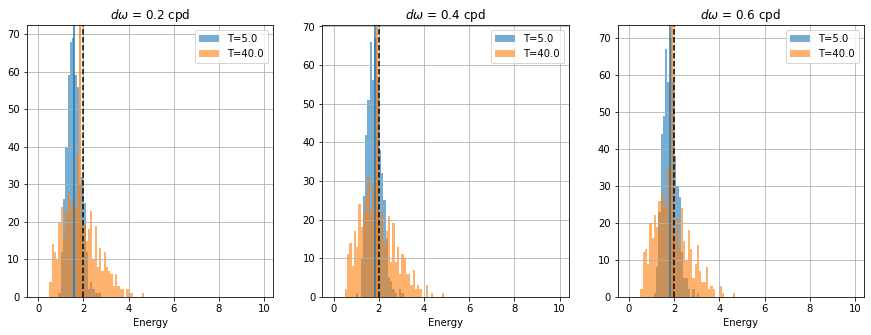

In [7]:
v = 'MS_demodulated'
s = 'mixed'
u = 1
bins = np.arange(0,10,.1)
fig, axs = plt.subplots(1,ds_hf.bandwidth.size, 
                        figsize=(5*ds_hf.bandwidth.size,5),sharey=False)
for i,db in enumerate(ds_hf.bandwidth):
    ax = axs[i]
    _ = ds_hf.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
    for k,_T in enumerate(_.T):
        _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
        ax.axvline(_[v].sel(T=_T).mean(), color=f"C{k}")
    ax.legend();ax.set_xlabel('Energy')
    ax.grid();ax.set_title(r'$d\omega$ = %s cpd'%db.values);
    ax.axvline(2*u,c='k',linestyle='--')
fig.savefig(fig_dir+'bpass_distrib.png')

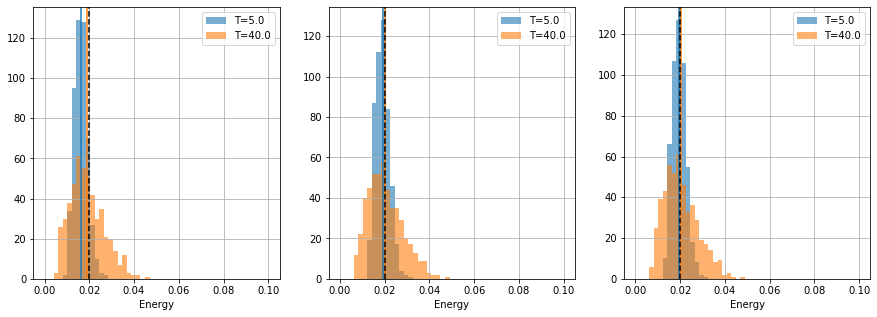

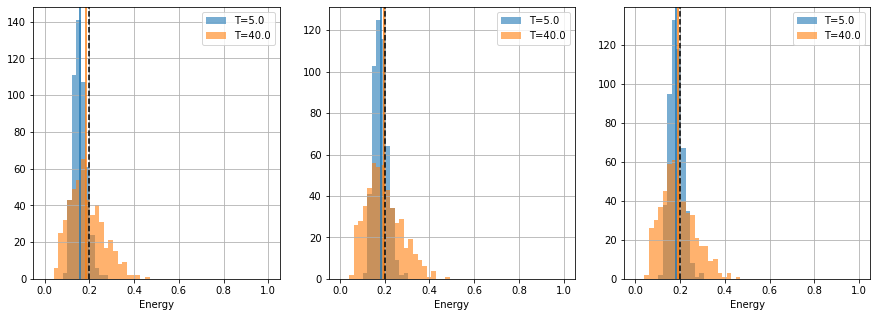

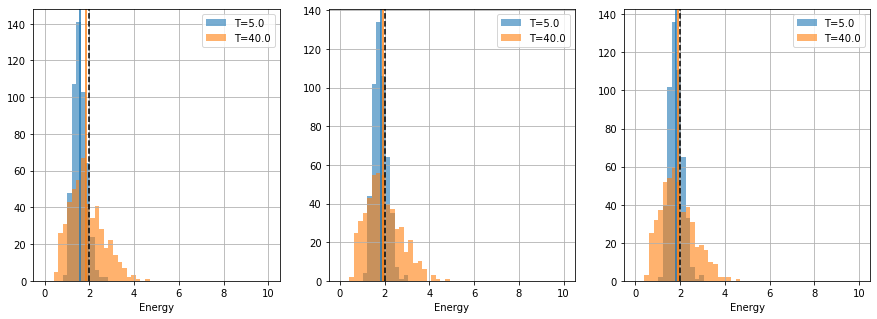

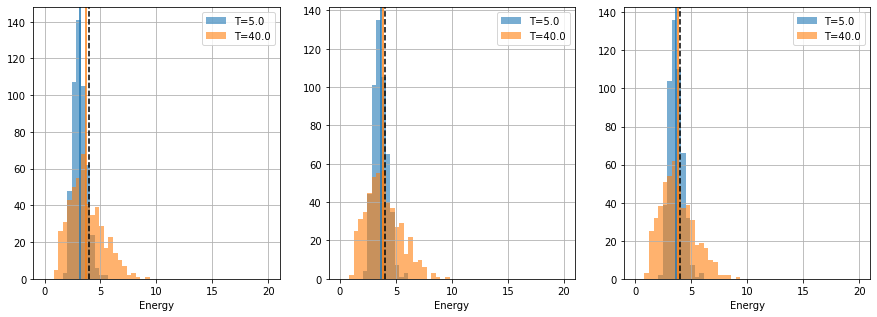

In [9]:
#bins = np.arange(0,10,.1)
Tlow = 20
for j,u in enumerate(ds_total.rms):
    bins = np.linspace(0,10*u)
    fig, axs = plt.subplots(1,ds_total.bandwidth.size, 
                        figsize=(5*ds_total.bandwidth.size,5),sharey=False)
    for i,db in enumerate(ds_hf.bandwidth):
        ax = axs[i]
        _ = ds_total.sel(rms=u,bandwidth=db,signal=s,T_low=Tlow).sel(T=[5,40])
        for k,_T in enumerate(_.T):
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
            ax.axvline(_[v].sel(T=_T).mean(), color=f"C{k}")
        ax.legend();ax.set_xlabel('Energy')
        ax.grid();ax.set_title('')
        ax.axvline(2*u,c='k',linestyle='--')
#    axs[0,:].set_title(r'$d\omega$ = %s cpd'%db.values);
    fig.savefig(fig_dir+'bpass_distrib_total_'+str(u)+'.png')

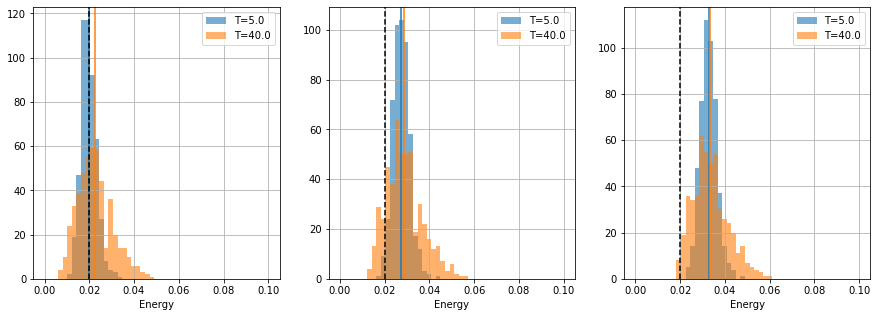

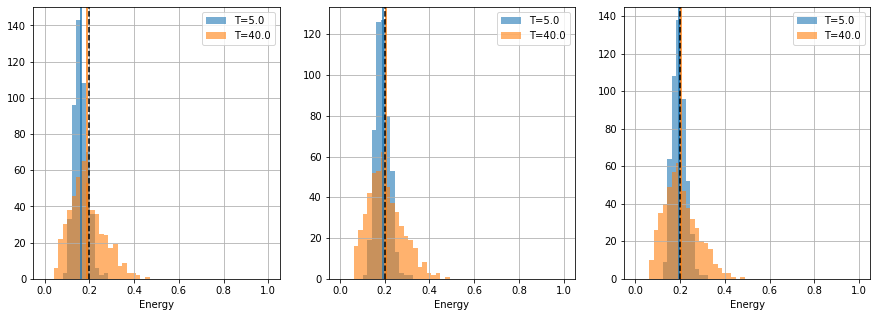

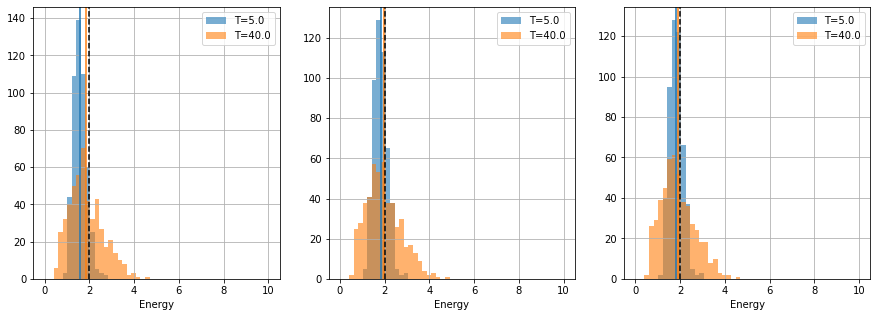

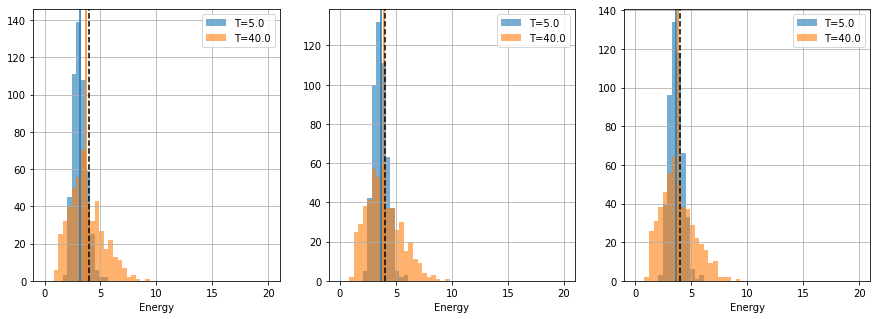

In [10]:
Tlow = 2
for j,u in enumerate(ds_total.rms):
    bins = np.linspace(0,10*u)
    fig, axs = plt.subplots(1,ds_total.bandwidth.size, 
                        figsize=(5*ds_total.bandwidth.size,5),sharey=False)
    for i,db in enumerate(ds_hf.bandwidth):
        ax = axs[i]
        _ = ds_total.sel(rms=u,bandwidth=db,signal=s,T_low=Tlow).sel(T=[5,40])
        for k,_T in enumerate(_.T):
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
            ax.axvline(_[v].sel(T=_T).mean(), color=f"C{k}")
        ax.legend();ax.set_xlabel('Energy')
        ax.grid();ax.set_title('')
        ax.axvline(2*u,c='k',linestyle='--')
#    axs[0,:].set_title(r'$d\omega$ = %s cpd'%db.values);
    fig.savefig(fig_dir+'bpass_distrib_total_'+str(u)+'_T2.png')

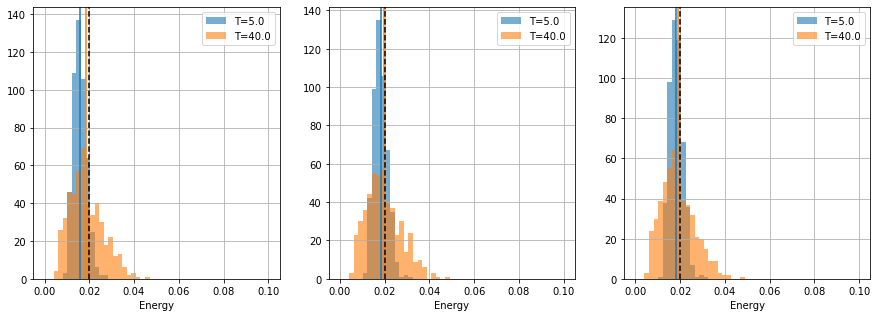

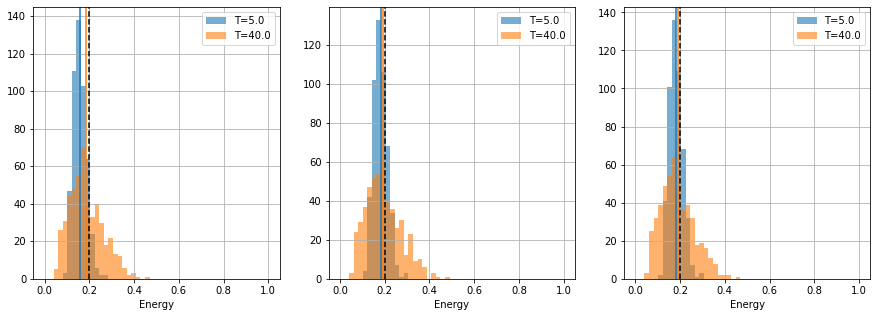

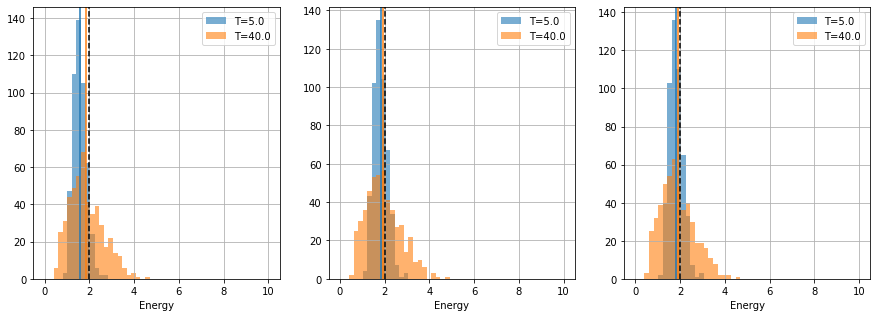

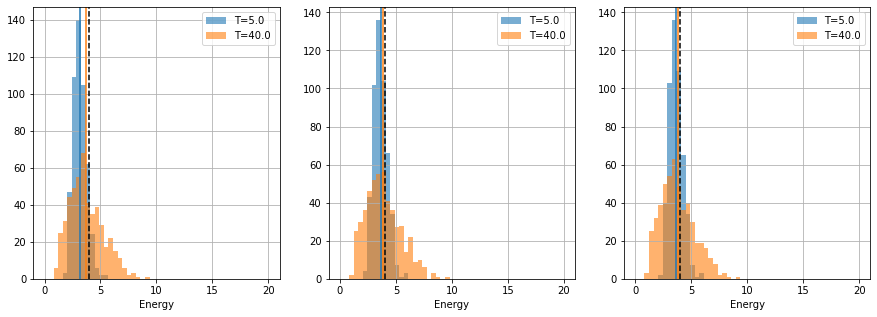

In [11]:
Tlow = 200
for j,u in enumerate(ds_total.rms):
    bins = np.linspace(0,10*u)
    fig, axs = plt.subplots(1,ds_total.bandwidth.size, 
                        figsize=(5*ds_total.bandwidth.size,5),sharey=False)
    for i,db in enumerate(ds_hf.bandwidth):
        ax = axs[i]
        _ = ds_total.sel(rms=u,bandwidth=db,signal=s,T_low=Tlow).sel(T=[5,40])
        for k,_T in enumerate(_.T):
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
            ax.axvline(_[v].sel(T=_T).mean(), color=f"C{k}")
        ax.legend();ax.set_xlabel('Energy')
        ax.grid();ax.set_title('')
        ax.axvline(2*u,c='k',linestyle='--')
#    axs[0,:].set_title(r'$d\omega$ = %s cpd'%db.values);
    fig.savefig(fig_dir+'bpass_distrib_total_'+str(u)+'_T200.png')

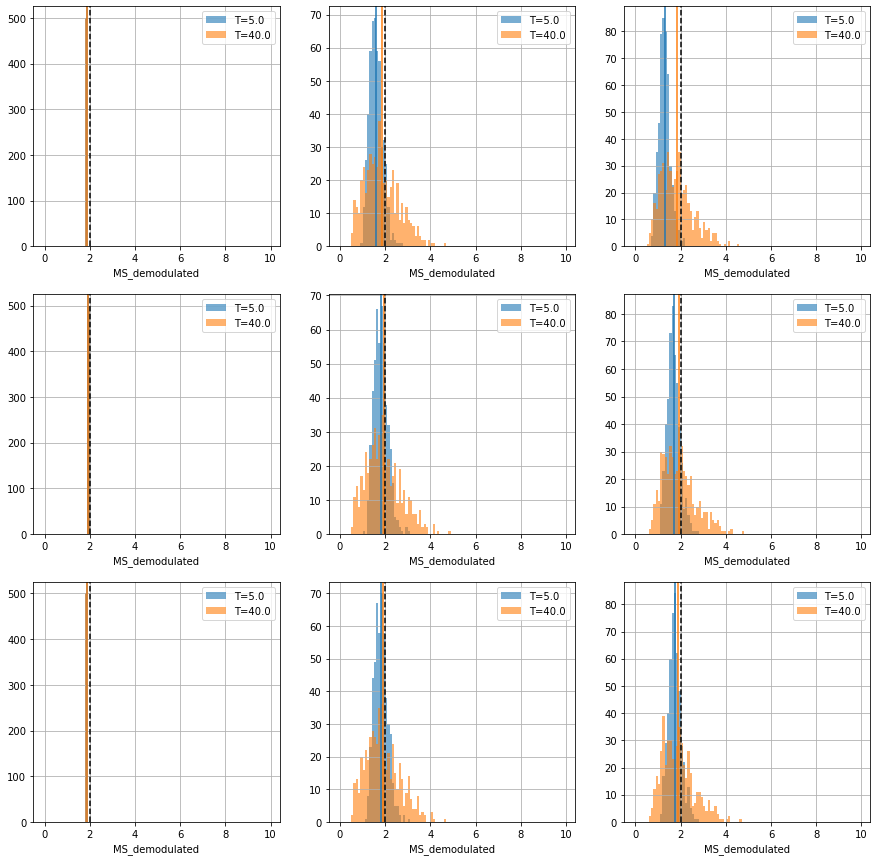

In [12]:
v = 'MS_demodulated'
u = 1
bins = np.arange(0,10,.1)
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=False)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_hf.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        for k,_T in enumerate(_.T):
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
            ax.axvline(_[v].sel(T=_T).mean(), color=f"C{k}")
        ax.legend();
        ax.grid();ax.set_title('');
        ax.axvline(2*u,c='k',linestyle='--')
fig.savefig(fig_dir+'bpass_estimates_distrib.png')

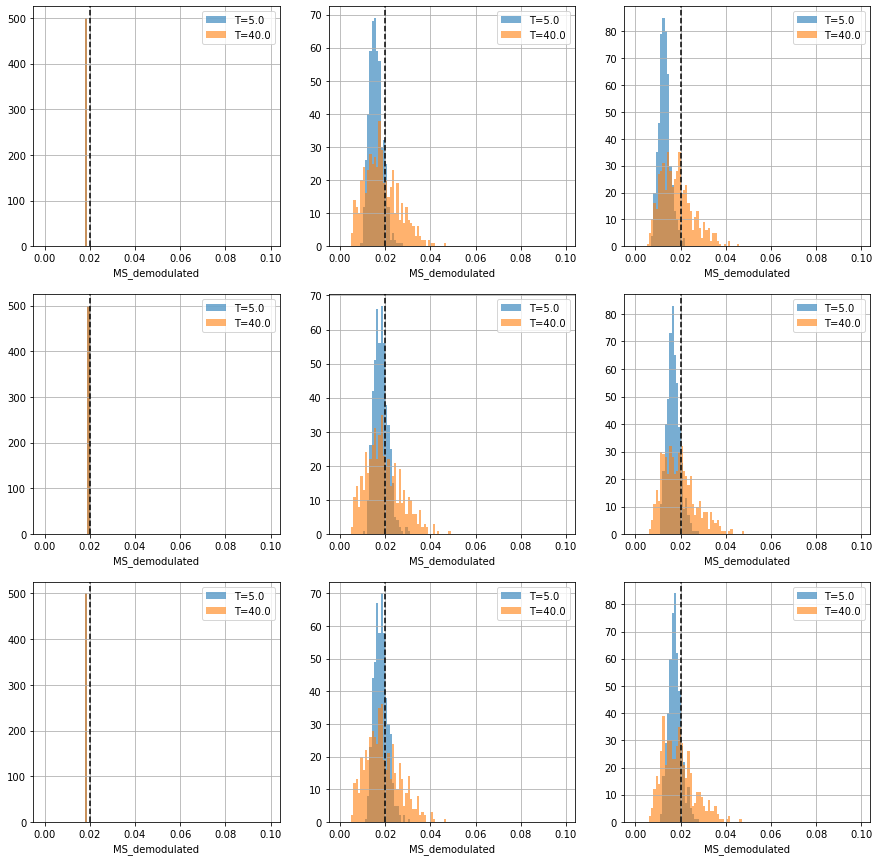

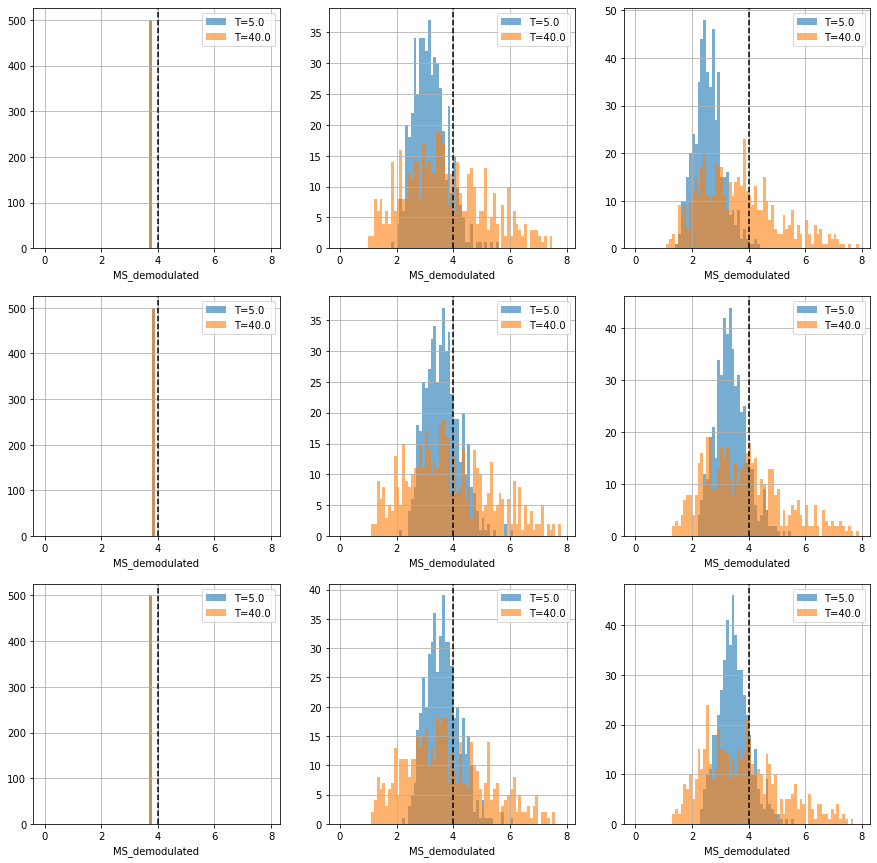

In [13]:
u = 0.01
bins = np.arange(0,0.1,.001)
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=False)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_hf.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        for _T in _.T:
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
        ax.legend()
        ax.grid();ax.set_title('')
        ax.axvline(2*u,c='k',linestyle='--')
fig.savefig(fig_dir+'bpass_estimates_distrib_u001.png')

u = 2
bins = np.arange(0,8,.1)
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=False)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_hf.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        for _T in _.T:
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
        ax.legend()
        ax.grid();ax.set_title('');
        ax.axvline(2*u,c='k',linestyle='--')
fig.savefig(fig_dir+'bpass_estimates_distrib_u2.png')

### Autocovariance hf only

In [7]:
def th_autocov_M2(tau,V,T):
    return V*np.exp(-tau/T)


In [9]:
ds_mean = autocov_hf.mean('draw').compute()
#ds_mean_total = autocov_total.mean('draw').compute()

In [10]:
ds_mean = ds_mean.sel(lags=slice(0,150))
ds_mean_total = ds_mean_total.sel(lags=slice(0,150))

In [11]:
tau = ds_mean_total.lags.values

In [12]:
def th_autocov_MS(tau,V,T):
    return V*np.exp(-tau/T)*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_mixed(tau,V,T):
    return V/2*(2+np.exp(-tau/T))*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_coh(tau,V,T):
    return 2*V*np.cos((omega_S2-omega_M2)*np.pi*tau)

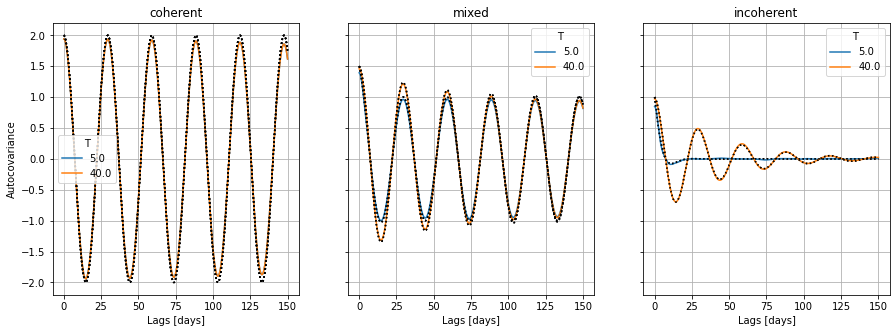

In [13]:
u = 1
fig, axs = plt.subplots(1,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5),sharey=True,sharex=True)
for j, s in enumerate(ds_hf.signal):
    ax = axs[j]
    _ = ds_mean.sel(rms=u,bandwidth=0.4,signal=s).sel(T=[5,40])
    _.MS_real_real.plot(ax=ax,hue='T')
    ax.grid();ax.set_title(r'%s'%(s.values));
    ax.set_ylabel('');ax.set_xlabel('')
    axs[0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[0].set_ylabel('Autocovariance');
for j in range(3):
    axs[j].set_xlabel('Lags [days]')

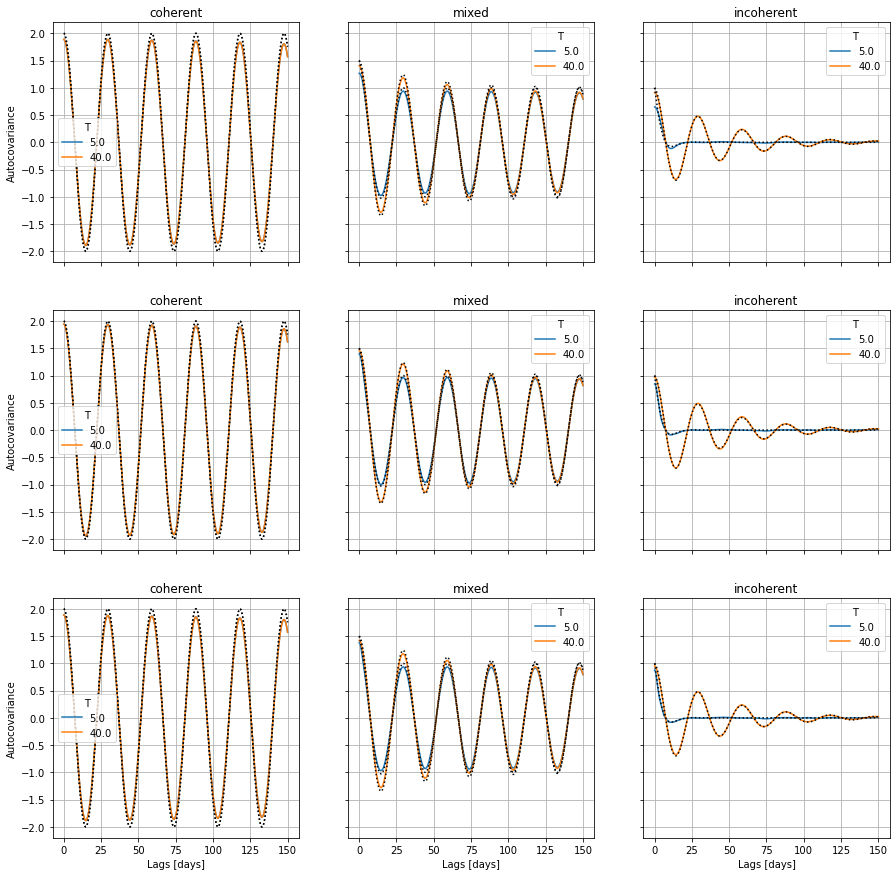

In [18]:
u = 1
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_mean.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s'%(s.values));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
#fig.savefig(fig_dir+'autocov_hf_u1.png')

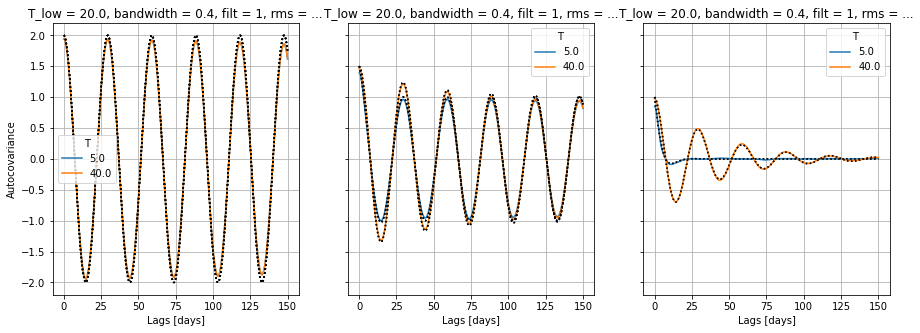

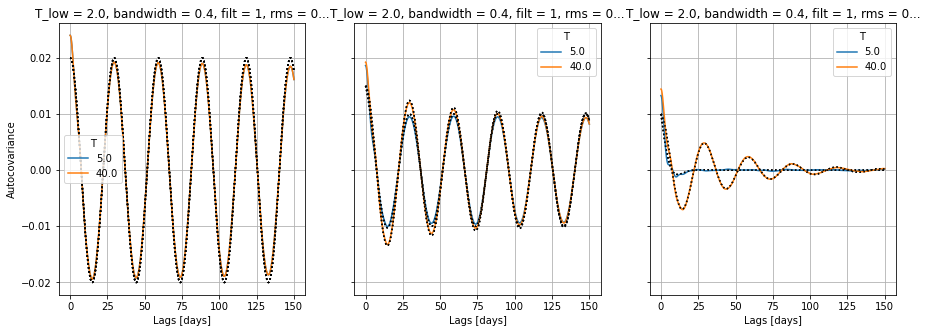

In [22]:
#Total
u = 1
Tl = 20
fig, axs = plt.subplots(1,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5),sharey=True,sharex=True)
for j, s in enumerate(ds_hf.signal):
    ax = axs[j]
    _ = ds_mean_total.sel(rms=u,bandwidth=0.4,signal=s,T_low=Tl).sel(T=[5,40])
    _.MS_real_real.plot(ax=ax,hue='T')
    ax.grid()#;ax.set_title(r'%s'%(s.values));
    ax.set_ylabel('');ax.set_xlabel('')
    axs[0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[0].set_ylabel('Autocovariance');
for j in range(3):
    axs[j].set_xlabel('Lags [days]')
    
u = 0.01
Tl = 2
fig, axs = plt.subplots(1,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5),sharey=True,sharex=True)
for j, s in enumerate(ds_hf.signal):
    ax = axs[j]
    _ = ds_mean_total.sel(rms=u,bandwidth=0.4,signal=s,T_low=Tl).sel(T=[5,40])
    _.MS_real_real.plot(ax=ax,hue='T')
    ax.grid()#;ax.set_title(r'%s'%(s.values));
    ax.set_ylabel('');ax.set_xlabel('')
    axs[0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[0].set_ylabel('Autocovariance');
for j in range(3):
    axs[j].set_xlabel('Lags [days]')

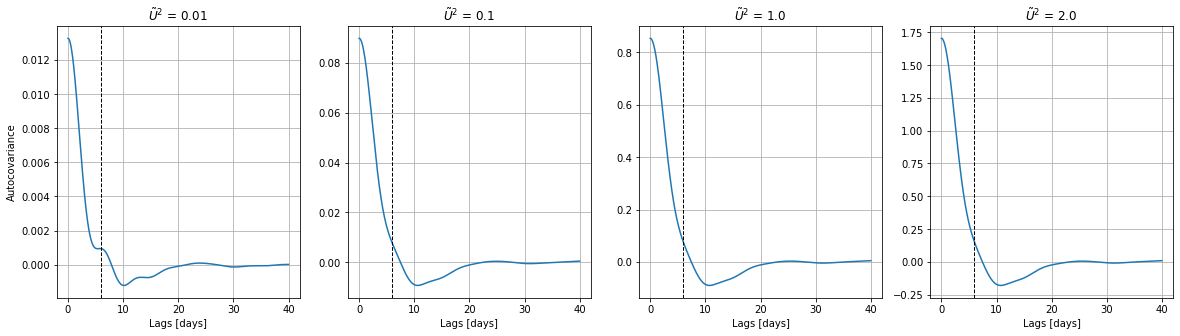

In [44]:
fig,ax = plt.subplots(1,ds_mean_total.rms.size,figsize=(5*ds_mean_total.rms.size,5))
for i,u in enumerate(ds_mean_total.rms.values):
    _ = ds_mean_total.sel(rms=u,bandwidth=0.4,signal='incoherent',T=5,T_low=2).sel(lags=slice(0,40))
    _.MS_real_real.plot(ax=ax[i],hue='T_low')
    ax[i].grid();ax[i].set_title(r'$\tilde{U}^2$ = %s'%_.rms.values);ax[i].set_ylabel('');
    ax[i].set_xlabel('Lags [days]');ax[i].axvline(6,c='k',linestyle='--',linewidth=1)
ax[0].set_ylabel('Autocovariance');

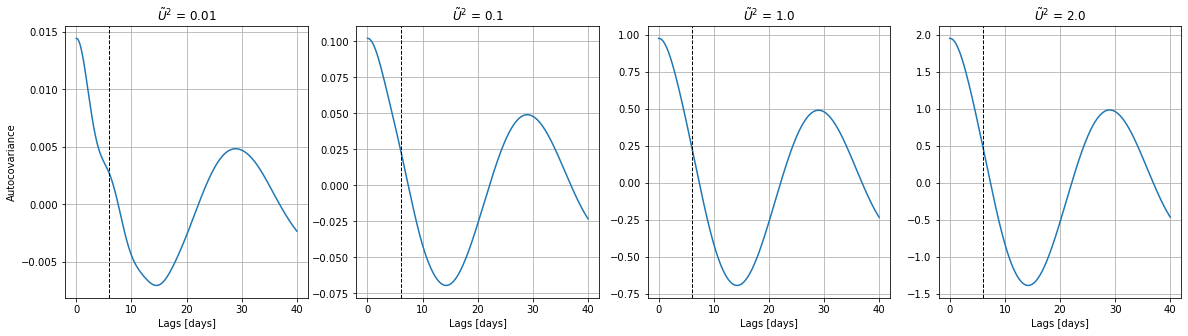

In [14]:
fig,ax = plt.subplots(1,ds_mean_total.rms.size,figsize=(5*ds_mean_total.rms.size,5))
for i,u in enumerate(ds_mean_total.rms.values):
    _ = ds_mean_total.sel(rms=u,bandwidth=0.4,signal='incoherent',T=40,T_low=2).sel(lags=slice(0,40))
    _.MS_real_real.plot(ax=ax[i],hue='T_low')
    ax[i].grid();ax[i].set_title(r'$\tilde{U}^2$ = %s'%_.rms.values);ax[i].set_ylabel('');
    ax[i].set_xlabel('Lags [days]');ax[i].axvline(6,c='k',linestyle='--',linewidth=1)
ax[0].set_ylabel('Autocovariance');

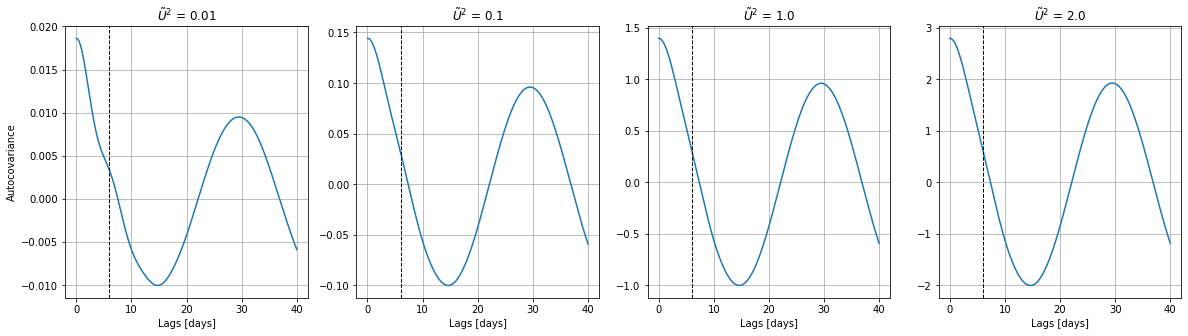

In [15]:
fig,ax = plt.subplots(1,ds_mean_total.rms.size,figsize=(5*ds_mean_total.rms.size,5))
for i,u in enumerate(ds_mean_total.rms.values):
    _ = ds_mean_total.sel(rms=u,bandwidth=0.4,signal='mixed',T=5,T_low=2).sel(lags=slice(0,40))
    _.MS_real_real.plot(ax=ax[i],hue='T_low')
    ax[i].grid();ax[i].set_title(r'$\tilde{U}^2$ = %s'%_.rms.values);ax[i].set_ylabel('');
    ax[i].set_xlabel('Lags [days]');ax[i].axvline(6,c='k',linestyle='--',linewidth=1)
ax[0].set_ylabel('Autocovariance');

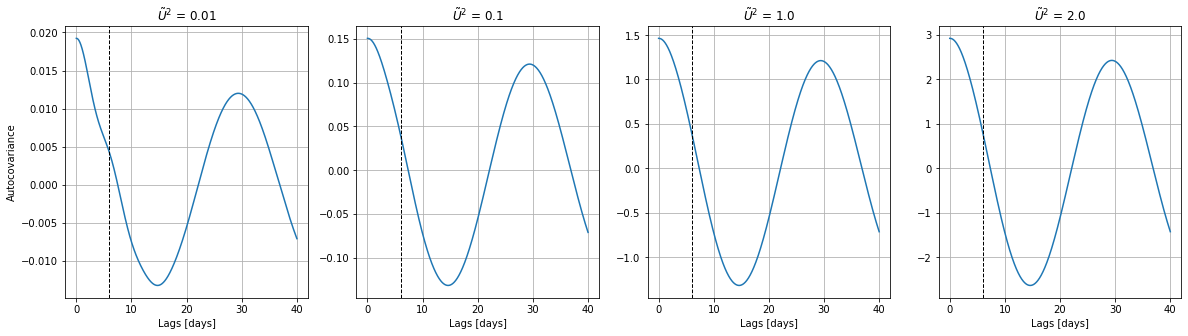

In [16]:
fig,ax = plt.subplots(1,ds_mean_total.rms.size,figsize=(5*ds_mean_total.rms.size,5))
for i,u in enumerate(ds_mean_total.rms.values):
    _ = ds_mean_total.sel(rms=u,bandwidth=0.4,signal='mixed',T=40,T_low=2).sel(lags=slice(0,40))
    _.MS_real_real.plot(ax=ax[i],hue='T_low')
    ax[i].grid();ax[i].set_title(r'$\tilde{U}^2$ = %s'%_.rms.values);ax[i].set_ylabel('');
    ax[i].set_xlabel('Lags [days]');ax[i].axvline(6,c='k',linestyle='--',linewidth=1)
ax[0].set_ylabel('Autocovariance');

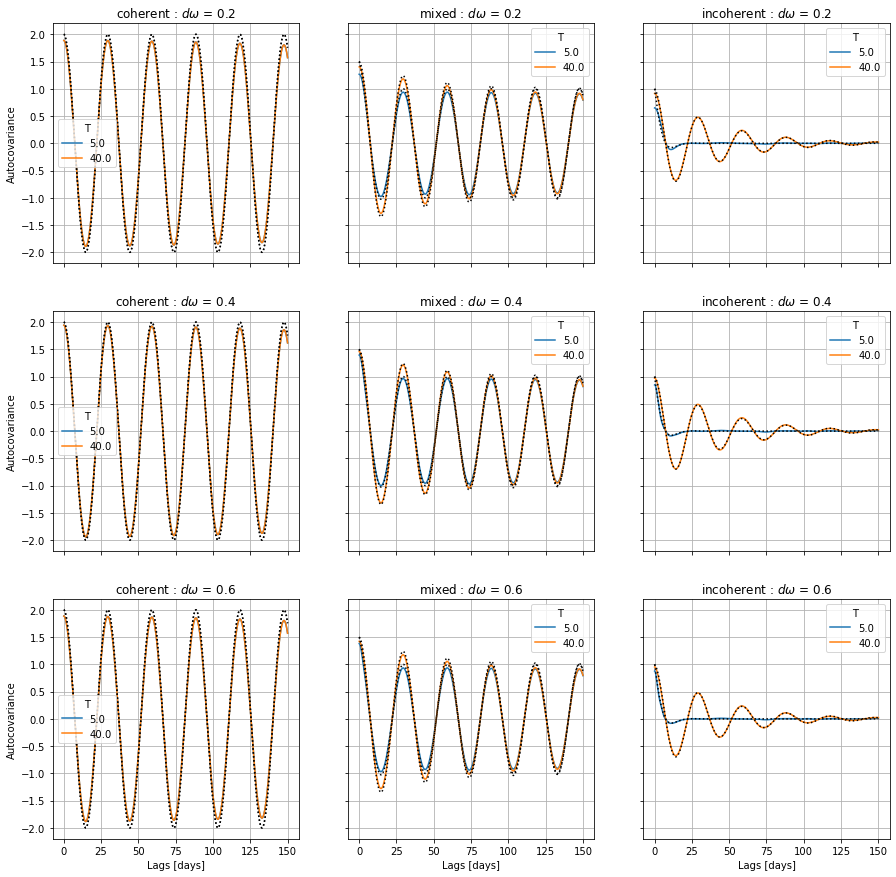

In [39]:
u = 1
Tl = 20
fig, axs = plt.subplots(ds_total.bandwidth.size,ds_total.signal.size, 
                        figsize=(5*ds_total.signal.size,5*ds_total.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_total.bandwidth):
    for j, s in enumerate(ds_total.signal):
        ax = axs[i,j]
        _ = ds_mean_total.sel(rms=u,bandwidth=db,signal=s,T_low = Tl).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_total_u1_T20.png')

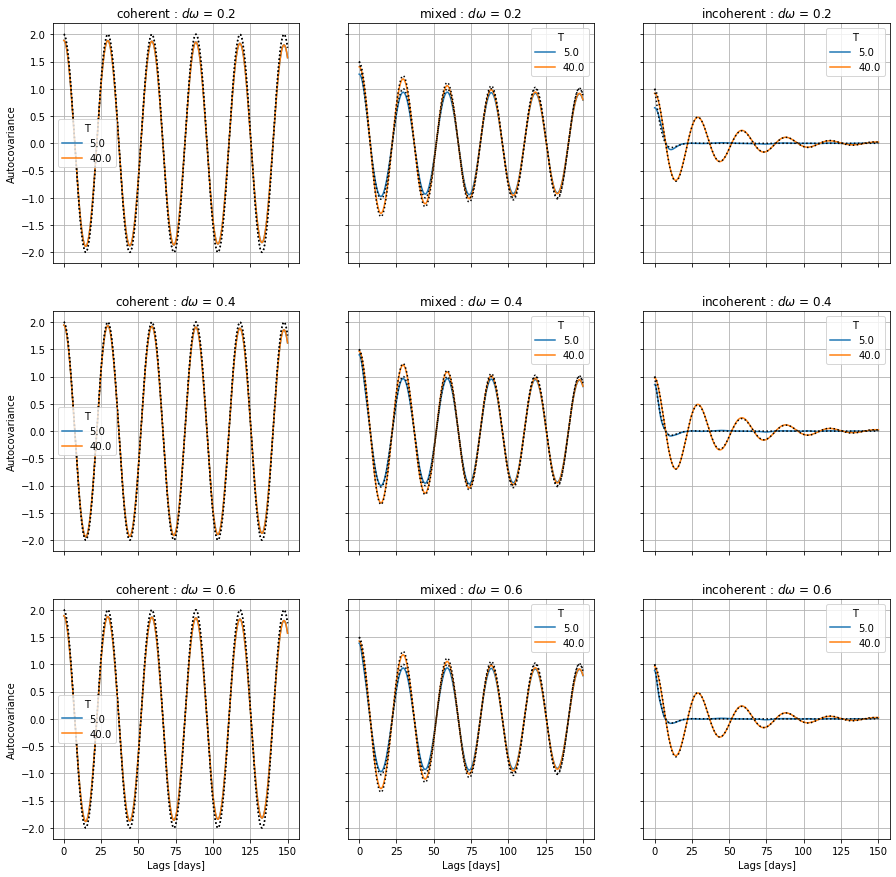

In [40]:
u = 1
Tl = 2
fig, axs = plt.subplots(ds_total.bandwidth.size,ds_total.signal.size, 
                        figsize=(5*ds_total.signal.size,5*ds_total.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_total.bandwidth):
    for j, s in enumerate(ds_total.signal):
        ax = axs[i,j]
        _ = ds_mean_total.sel(rms=u,bandwidth=db,signal=s,T_low = Tl).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_total_u1_T2.png')

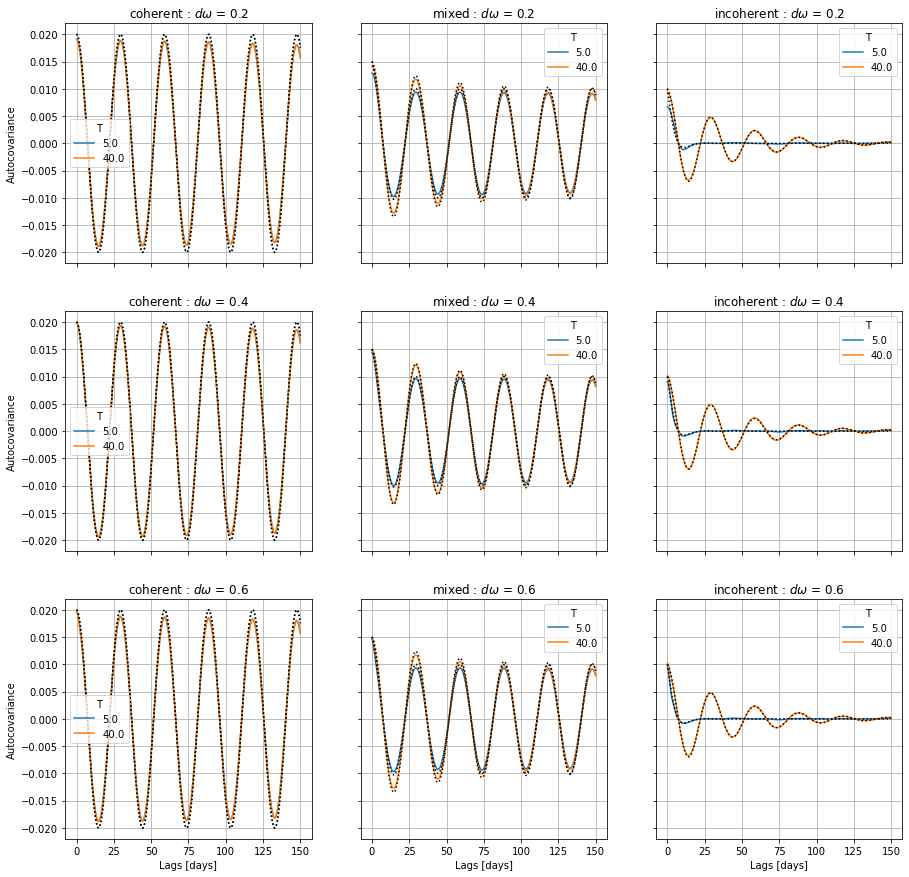

In [37]:
u = 0.01
Tl = 20
fig, axs = plt.subplots(ds_total.bandwidth.size,ds_total.signal.size, 
                        figsize=(5*ds_total.signal.size,5*ds_total.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_total.bandwidth):
    for j, s in enumerate(ds_total.signal):
        ax = axs[i,j]
        _ = ds_mean_total.sel(rms=u,bandwidth=db,signal=s,T_low = Tl).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_total_u001.png')

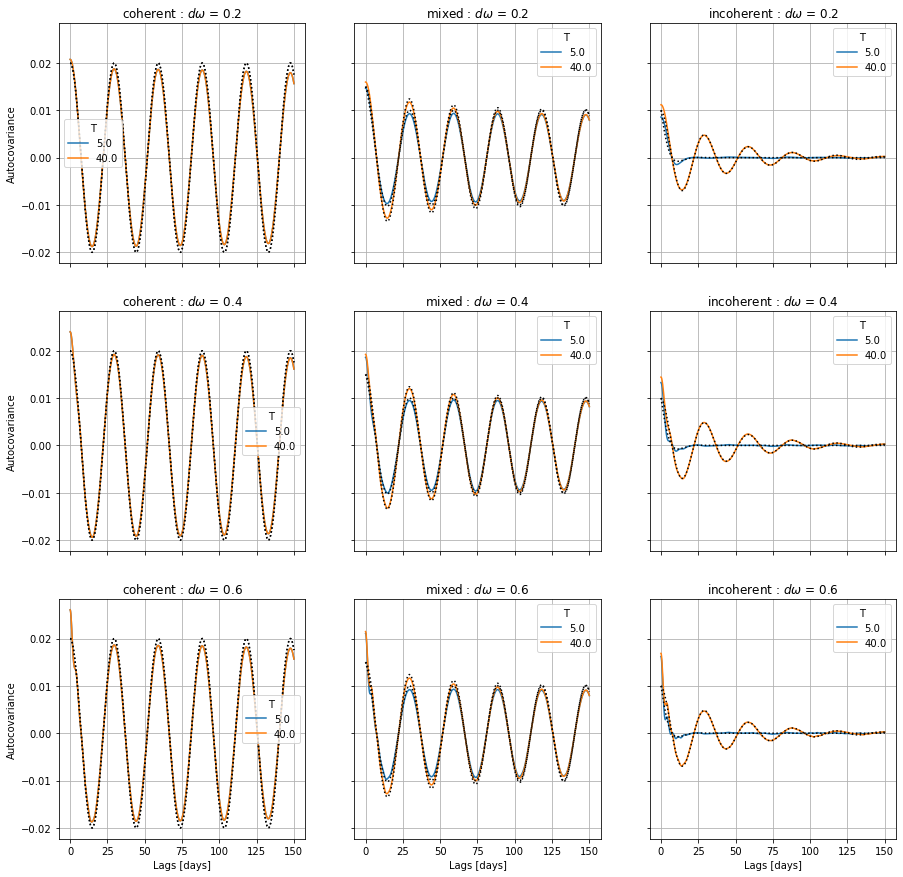

In [38]:
u = 0.01
Tl = 2
fig, axs = plt.subplots(ds_total.bandwidth.size,ds_total.signal.size, 
                        figsize=(5*ds_total.signal.size,5*ds_total.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_total.bandwidth):
    for j, s in enumerate(ds_total.signal):
        ax = axs[i,j]
        _ = ds_mean_total.sel(rms=u,bandwidth=db,signal=s,T_low = Tl).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,40),c='k',linestyle='dotted')
    
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u,5),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u,5),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_total_u001_T2.png')

In [13]:
def zero_crossing(data,T,db,s):
    try : 
        out = data.where(np.sign(data).diff('lags')!=0,drop=True).sel(signal=s,bandwidth=db,T=T
                                                                     ).dropna('lags').isel(lags=0)
    except : 
        out = data.isel(lags=-1)
    return out
def wrap(data,T,db,s):
    zero = zero_crossing(data,T,db,s)
    #imin = np.min(0,zero.lags.values)
    #print(zero.lags.values,imin)
#    if zero == data.lags.max()
#        Tbar = xr.DataArray(0,coords={'T':T,'bandwidth':db,'signal':s}).rename('u') #
#    else:
    _ = data.sel(T=T,signal=s,bandwidth=db).sel(lags = slice(0,zero.lags.values))
    Tbar = (_).integrate('lags')
    return Tbar#.drop(['T','filt'])

def wrap_v2(data,T,db,s):
    _ = data.sel(T=T,signal=s,bandwidth=db)#.sel(lags = slice(0,zero.lags.values))
    Tbar = (_).integrate('lags')
    return Tbar#.drop(['T','filt'])

In [18]:
Tbar = {}
for t in ds_mean['T'].values:
    Tbar[t] = xr.combine_nested([[wrap(ds_mean['MS_real_real'],t,db,s) for s in ds_mean['signal'].values
                                 ] for db in ds_mean.bandwidth.values],concat_dim=['bandwidth','signal']
                       )#.assign_coords({'filt':ds_mean['filt'].values})
    Tbar[t] = Tbar[t].assign_coords({'signal':ds_mean.signal.values,'bandwidth':ds_mean.bandwidth.values})

In [16]:
Tbar_v2 = {}
for t in ds_mean['T'].values:
    Tbar_v2[t] = xr.combine_nested([[wrap_v2(ds_mean['MS_real_real'],t,db,s) for s in ds_mean['signal'].values
                                 ] for db in ds_mean.bandwidth.values],concat_dim=['bandwidth','signal']
                       )#.assign_coords({'filt':ds_mean['filt'].values})
    Tbar_v2[t] = Tbar_v2[t].assign_coords({'signal':ds_mean.signal.values,'bandwidth':ds_mean.bandwidth.values})

In [14]:
from inspect import signature
import scipy


# Parameters
myfunc = th_autocov_MS #function to use for the fit
bounds = ((0,0),(2,1000)) # bounds for the fit to avoid non physical results
ce,cl = 'lightseagreen','firebrick'
#tau = ds_mean.lags.values

rad = 2*np.pi

In [15]:
import scipy.optimize

In [19]:
_ds_mean = ds_mean.sel(rms=1)

In [16]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['bandwidth','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['bandwidth','lags'],np.expand_dims(yfit,axis=0)),
                     'error' : (['bandwidth','param'],np.expand_dims(np.sqrt(np.diag(cov)),axis=0))},
                     coords={'bandwidth':np.array([y['bandwidth'].values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lags.values})
    return out#yfit,params,cov

In [21]:
Tbar_fit = {}
s = 'incoherent'
v = 'MS_real_real'
myfunc = th_autocov_MS
for t_ in ds_mean['T'].values:
    print(t_)
    Tbar_fit[t_] = xr.concat([fit(tau,_ds_mean[v].sel(bandwidth=db,signal=s,T=t_),myfunc,bounds,norm=False
                             ) for db in ds_mean['bandwidth'].values[:]],dim='bandwidth')
    Tbar_fit[t_] = Tbar_fit[t_].assign_coords({'bandwidth':ds_mean.bandwidth.values})
#.assign_coords({'filt':ds_mean['filt'].values})

5.0
10.0
20.0
40.0


In [17]:
true_Tbar = ds_mean_total['T']

In [18]:
def Testimate(ds,s,u,myfunc,savefig=False,name=''):
    tau = ds.lags.values
    fig,ax = plt.subplots(1,ds['T'].size,figsize=(5*ds['T'].size,5),sharey=False)
    for i,t in enumerate(ds['T'].values):
        Tbar_fit = xr.concat([fit(tau,ds[v].sel(bandwidth=db,signal=s,T=t,rms=u),myfunc,bounds,norm=False
                             ) for db in ds['bandwidth'].values[:]],dim='bandwidth'
                        ).assign_coords({'bandwidth':ds.bandwidth.values})
        Tbar_v2 = xr.combine_nested([[wrap_v2(ds[v],t,db,s) for s in ds['signal'].values
                                 ] for db in ds.bandwidth.values],concat_dim=['bandwidth','signal']
                       ).assign_coords({'signal':ds.signal.values,'bandwidth':ds.bandwidth.values})
        Tb = Tbar_v2.sel(signal=s,rms=u)#.values
        Tb_fit = Tbar_fit.sel(param='T').params#.values
        (abs(Tb-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
        ).plot(ax=ax[i],c = 'k',marker='.',label=r'$\hat{\overline{T}}$ : integration');
        (abs(Tb_fit-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
         ).plot(ax=ax[i],c = 'r',marker='.',label=r'$\hat{\overline{T}}$ : fit');
        ax[i].grid();ax[i].axhline(0,c='k',linestyle='--',label=r'$\hat{\overline{T}} = \overline{T}$');
       # ax[i].set_title(r'True decorrelation timescale , $\overline{T}$ : %s days'%str(t));
        ax[i].set_title(r'$\frac{\vert\hat{\overline{T}}-\overline{T}\vert}{\overline{T}}$  , with $\overline{T}=$%s days'%str(t));
        ax[i].legend();
    if savefig:
        name = name+s+'_u'+ str(u)+'_T'+str(t)+'.png'
        fig.savefig(fig_dir+name)
    return Tbar_fit

In [19]:
def th_autocov_MS(tau,V,T):
    return V*np.exp(-tau/T)*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_mixed(tau,V,T):
    return V*(1+0.5*np.exp(-tau/T))*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_coh(tau,V,T):
    return V*np.cos((omega_S2-omega_M2)*np.pi*tau)

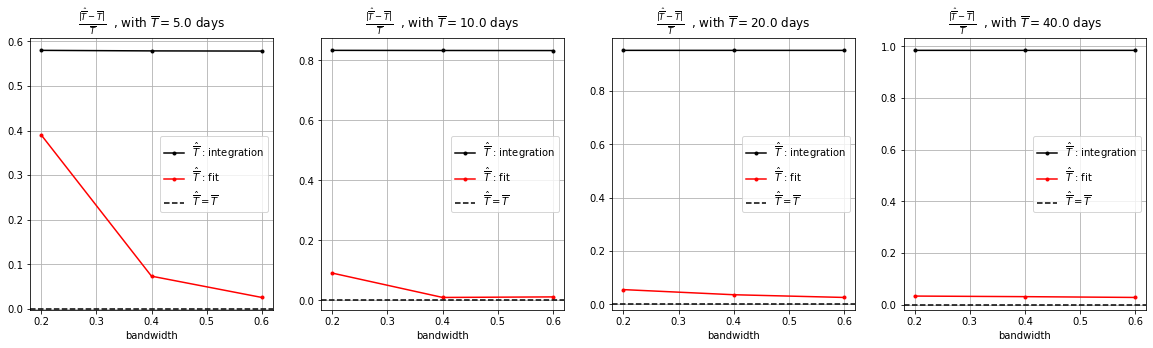

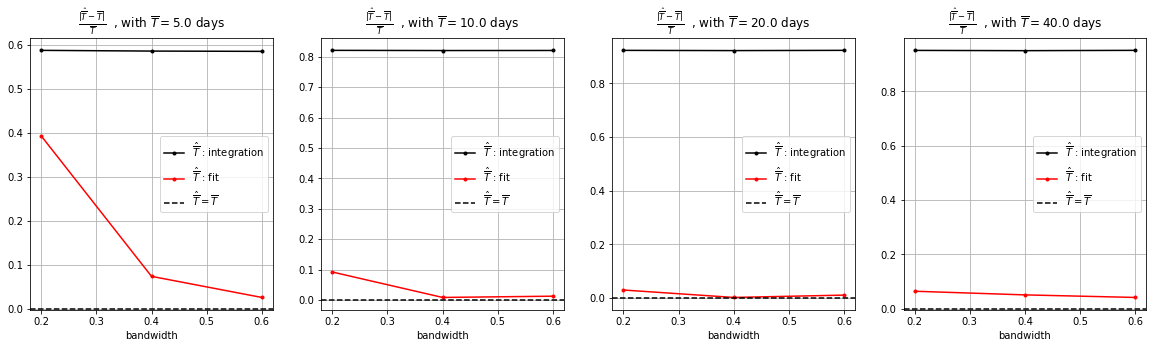

In [20]:
v = 'MS_real_real'
test = Testimate(ds_mean,'incoherent',1,th_autocov_MS,savefig=False)
test = Testimate(ds_mean.sel(lags=slice(0,40)),'incoherent',1,th_autocov_MS,savefig=False,name='lag40_')

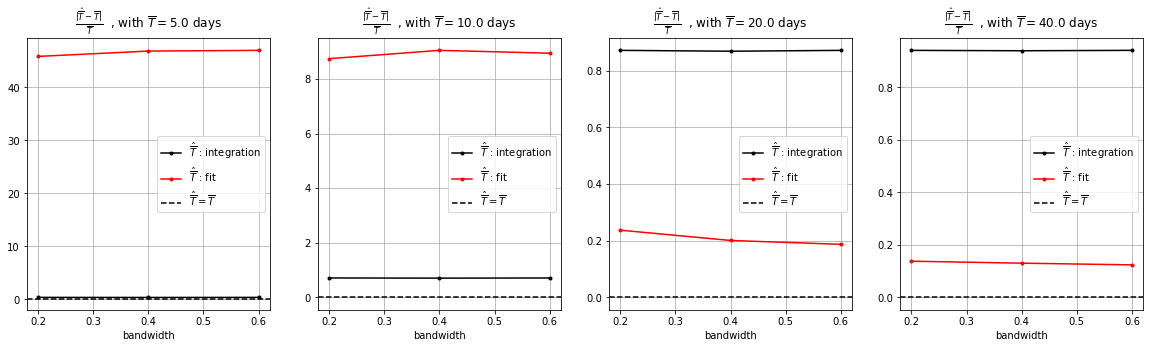

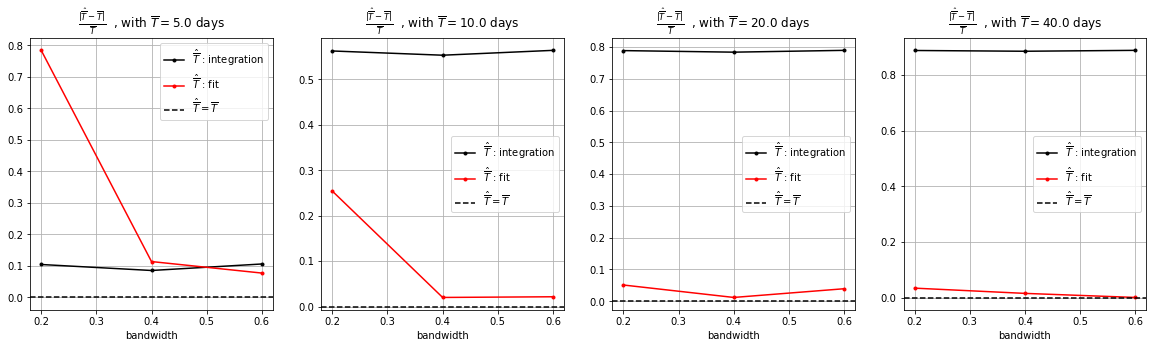

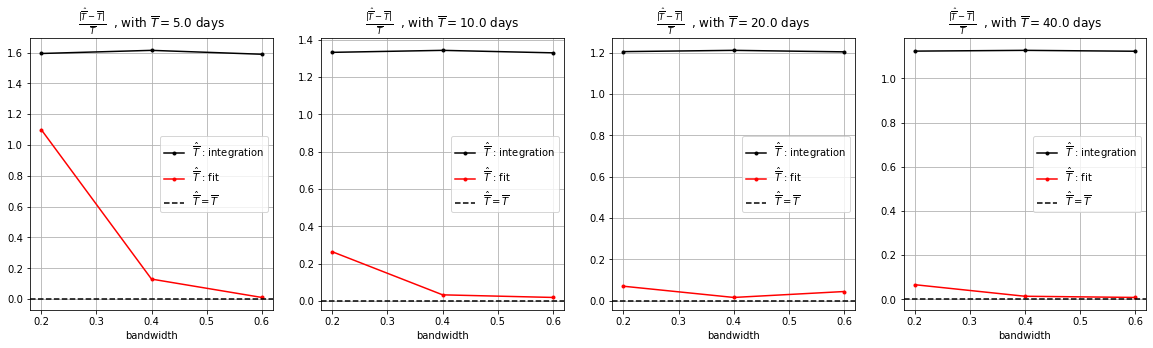

In [27]:
v = 'MS_real_real'
test = Testimate(ds_mean,'mixed',1,th_autocov_MS_mixed,savefig=False)
test = Testimate(ds_mean.sel(lags=slice(0,40)),'mixed',1,th_autocov_MS_mixed,savefig=False,name='lag40_')
test = Testimate(ds_mean.sel(lags=slice(0,20)),'mixed',1,th_autocov_MS_mixed,savefig=False,name='lag40_')

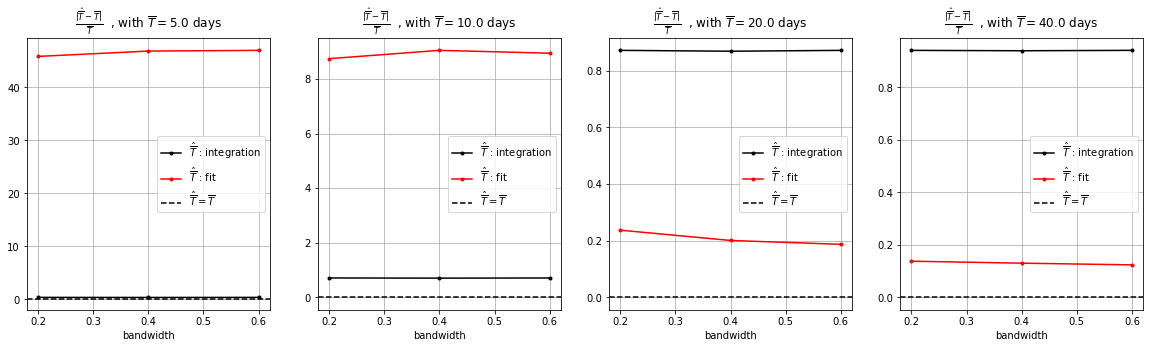

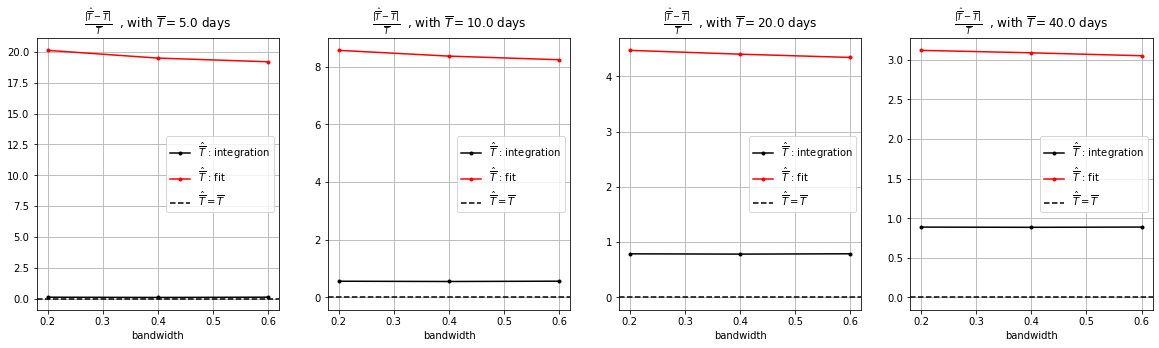

In [21]:
v = 'MS_real_real'
test = Testimate(ds_mean,'mixed',1,th_autocov_MS,savefig=False)
test = Testimate(ds_mean.sel(lags=slice(0,40)),'mixed',1,th_autocov_MS,savefig=False,name='lag40_')
#test = Testimate(ds_mean.sel(lags=slice(0,20)),'mixed',1,th_autocov_MS_mixed,savefig=False,name='lag40_')

In [28]:
def Testimate_total(ds,s,u,myfunc,savefig=False,name=''):
    tau = ds.lags.values
    fig,ax = plt.subplots(1,ds['T'].size,figsize=(5*ds['T'].size,5),sharey=False)
    for i,t in enumerate(ds['T'].values):
        Tbar_fit = xr.concat([fit(tau,ds[v].sel(bandwidth=db,signal=s,T=t,rms=u,T_low=Tl),myfunc,bounds,norm=False
                             ) for db in ds['bandwidth'].values[:]],dim='bandwidth'
                        ).assign_coords({'bandwidth':ds.bandwidth.values})
        Tbar_v2 = xr.combine_nested([[wrap_v2(ds[v],t,db,s) for s in ds['signal'].values
                                 ] for db in ds.bandwidth.values],concat_dim=['bandwidth','signal']
                       ).assign_coords({'signal':ds.signal.values,'bandwidth':ds.bandwidth.values})
        Tb = Tbar_v2.sel(signal=s,rms=u,T_low=Tl)#.values
        Tb_fit = Tbar_fit.sel(param='T').params#.values
        (abs(Tb-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
        ).plot(ax=ax[i],c = 'k',marker='.',label=r'$\hat{\overline{T}}$ : integration');
        (abs(Tb_fit-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
         ).plot(ax=ax[i],c = 'r',marker='.',label=r'$\hat{\overline{T}}$ : fit');
        ax[i].grid();ax[i].axhline(0,c='k',linestyle='--',label=r'$\hat{\overline{T}} = \overline{T}$');
       # ax[i].set_title(r'True decorrelation timescale , $\overline{T}$ : %s days'%str(t));
        ax[i].set_title(r'$\frac{\vert\hat{\overline{T}}-\overline{T}\vert}{\overline{T}}$  , with $\overline{T}=$%s days'%str(t));
        ax[i].legend();
    if savefig:
        name = name+s+'_u'+ str(u)+'_T'+str(t)+'.png'
        fig.savefig(fig_dir+name)
    return Tbar_fit

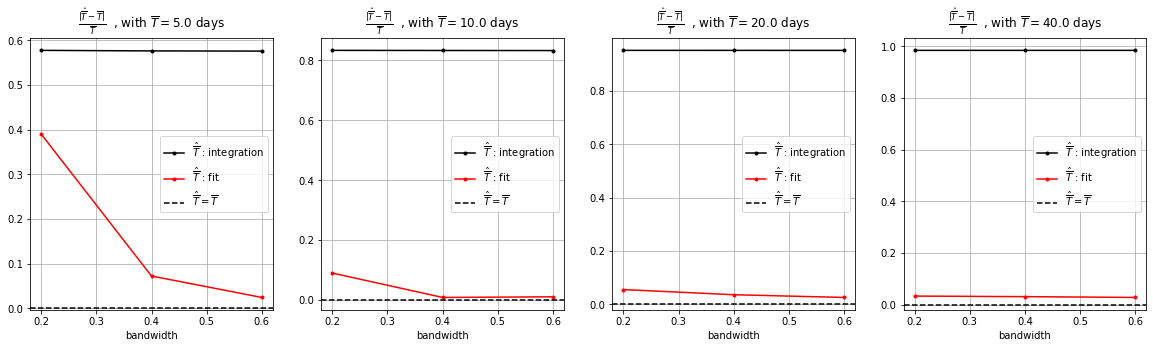

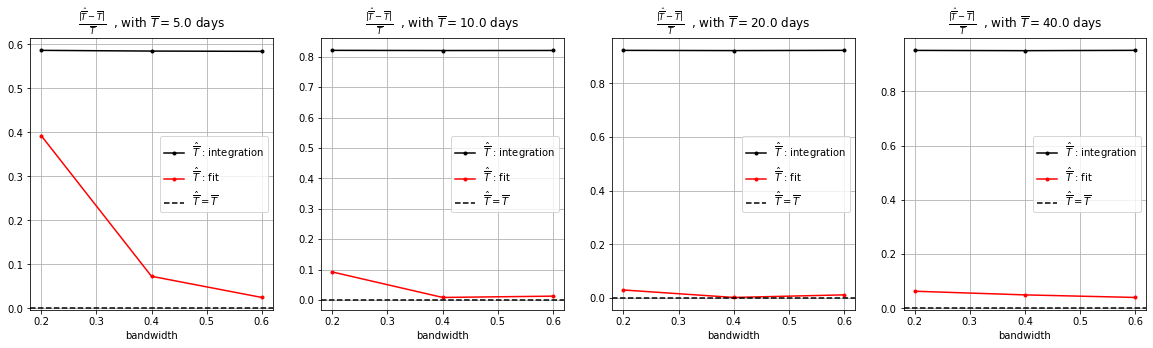

In [29]:
v = 'MS_real_real'
Tl = 20
u = 1
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,th_autocov_MS,savefig=False,name='total_lag40_')

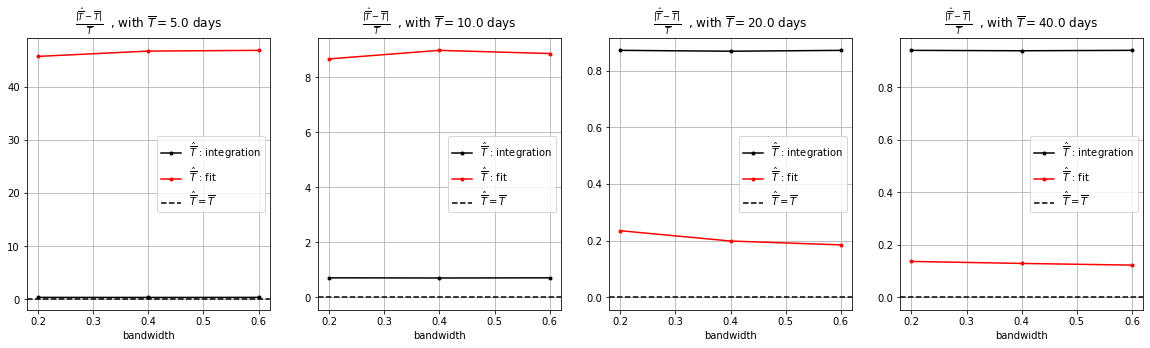

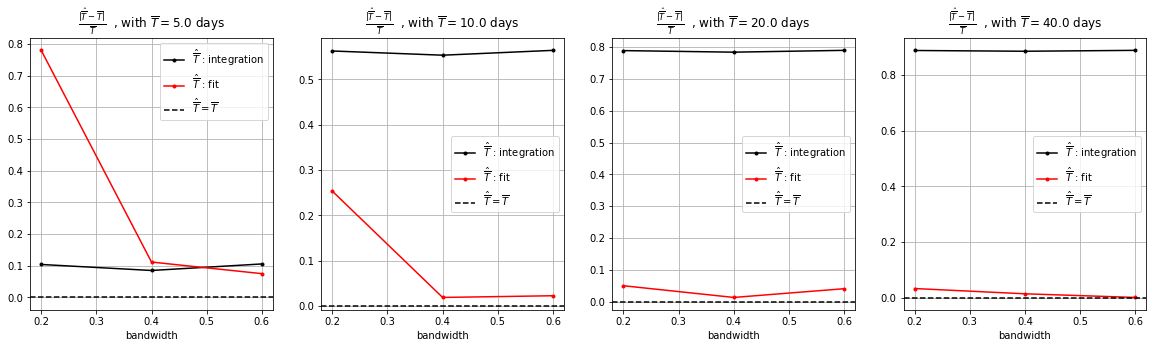

In [30]:
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_lag40_')

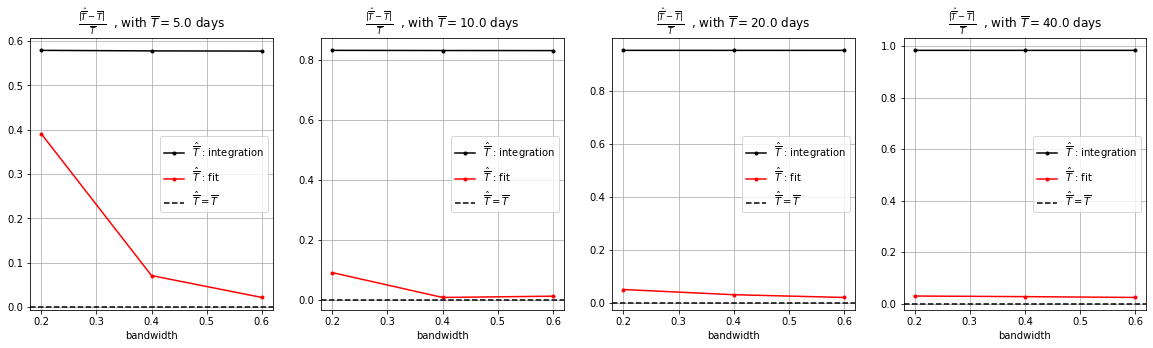

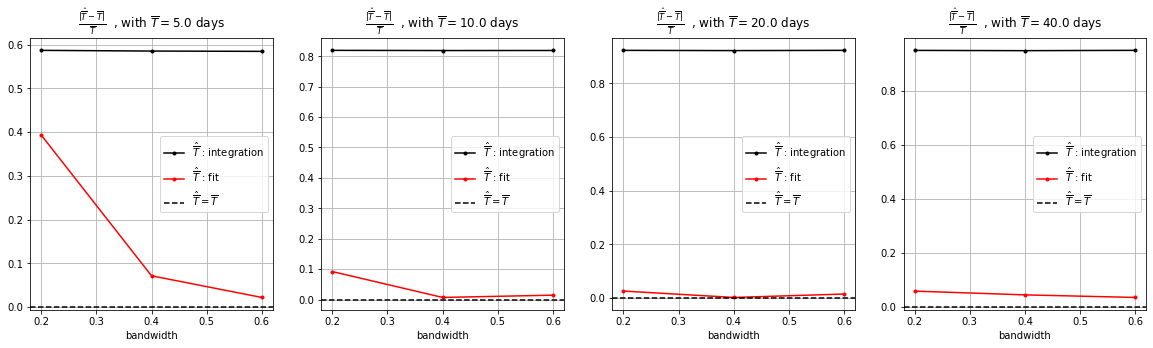

In [31]:
Tl = 2
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_T2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,
                       th_autocov_MS,savefig=False,name='total_T2_lag40_')

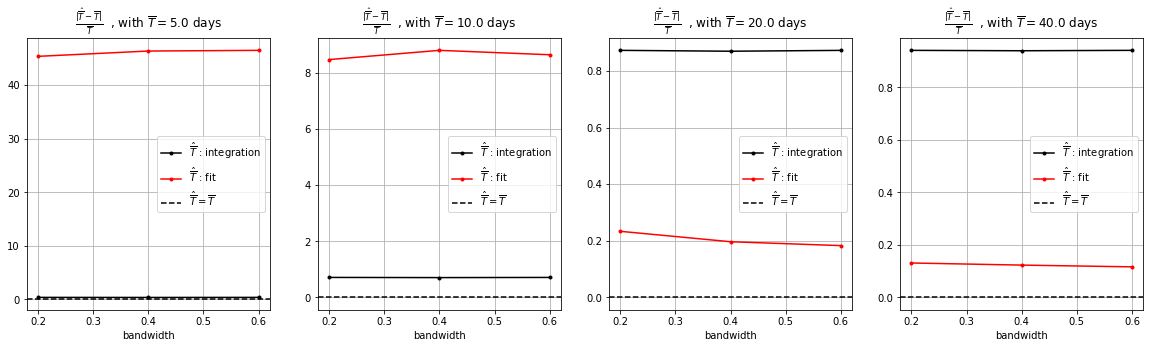

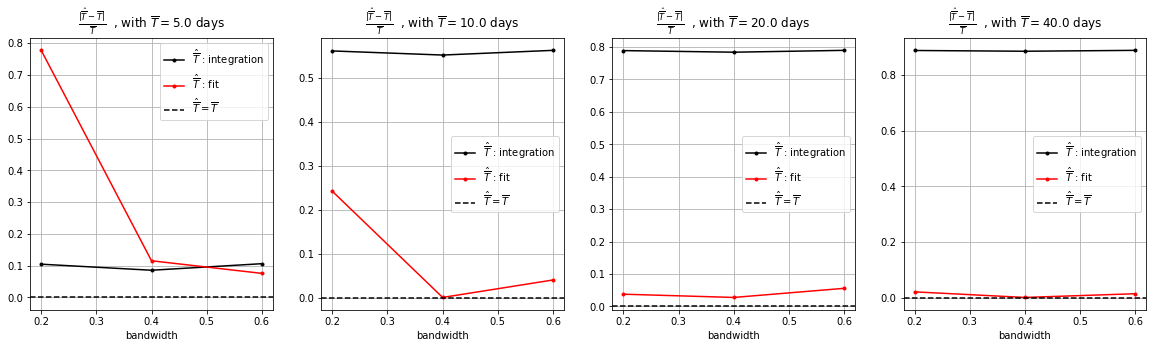

In [32]:
Tl = 2
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_T2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_T2_lag40_')

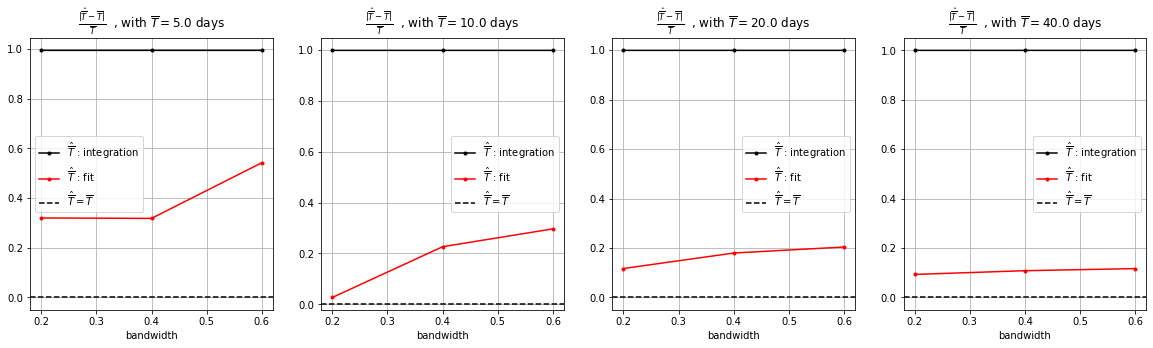

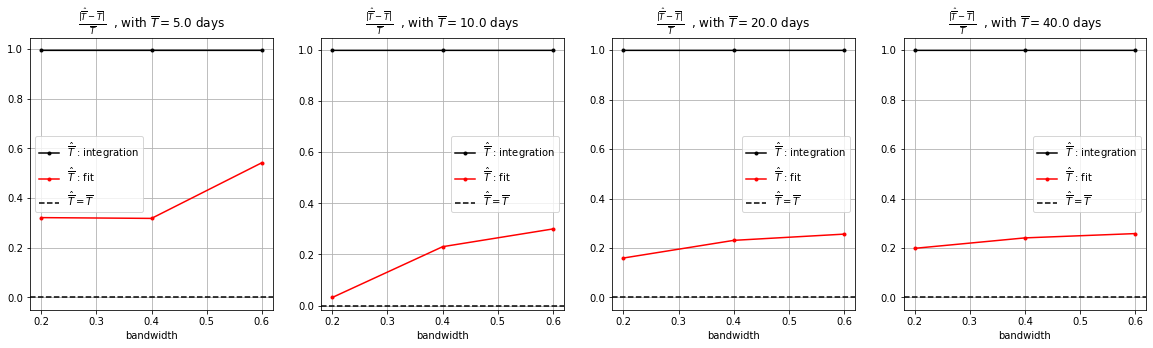

In [33]:
Tl = 2
u = 0.01
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl2_lag40_')

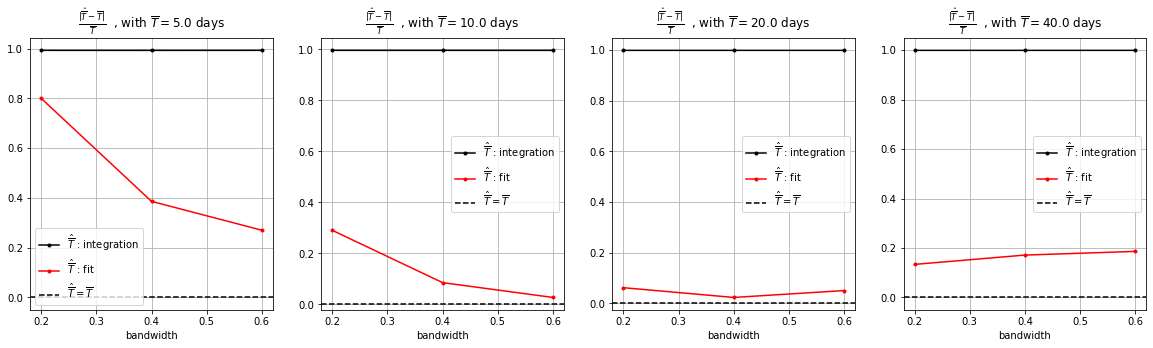

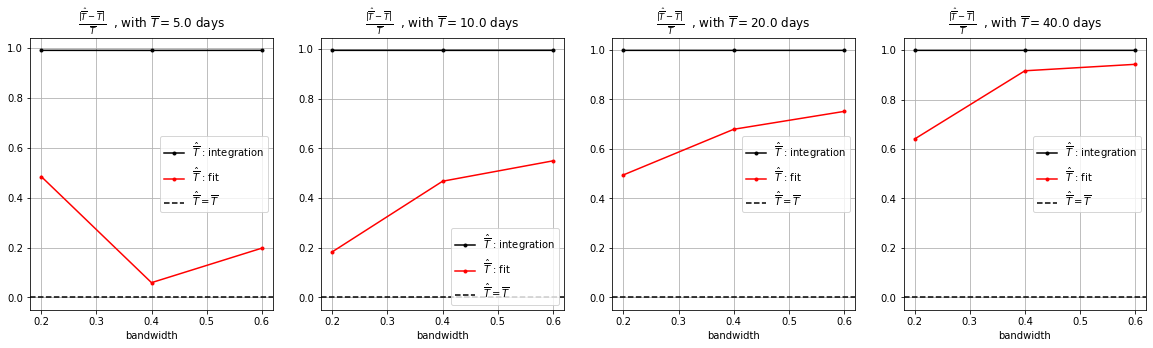

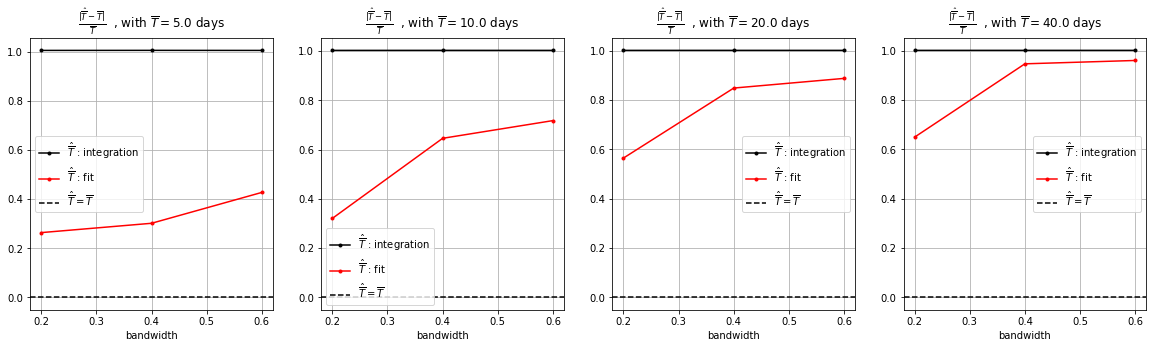

In [35]:
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl2_lag40_')

test = Testimate_total(ds_mean_total.sel(lags=slice(0,20)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl2_lag40_')

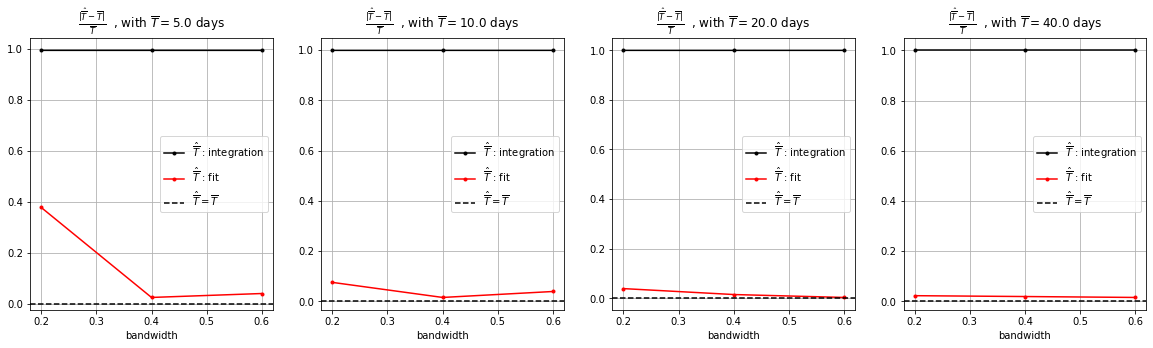

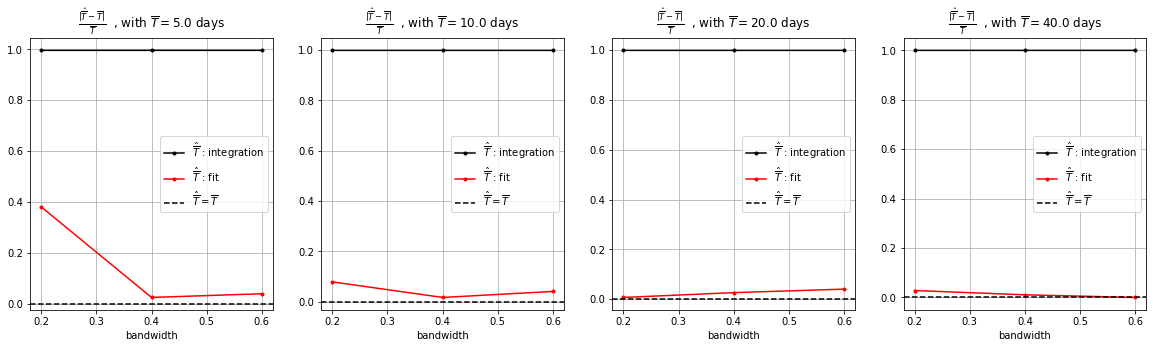

In [63]:
Tl = 20
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl20_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl20_lag40_')

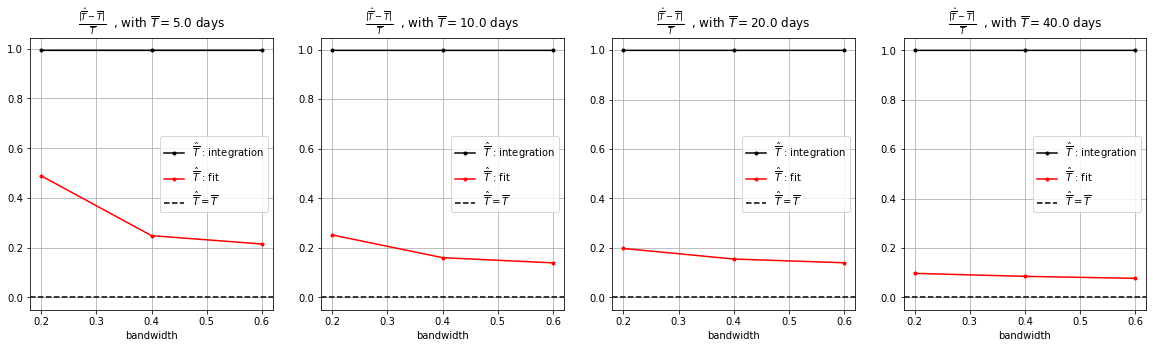

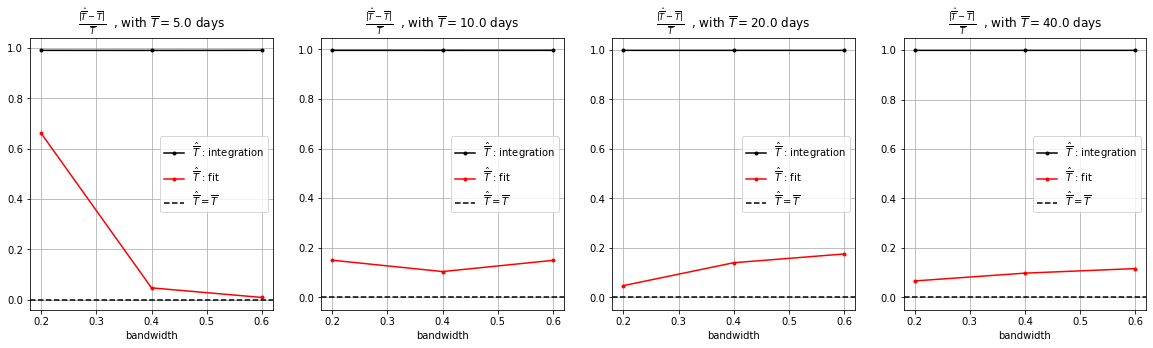

In [64]:
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl20_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl20_lag40_')

In [36]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/